In [1]:
import pandas as pd
import numpy as np

In [2]:
prostate = pd.read_csv('prostate_report.csv')
pirads = pd.read_csv('rad_df.csv') # Cleaned by Keith
data = pd.read_csv('labeled_df_wreports.csv') # Clean by Keith
demo = pd.read_csv('Atharv_features.csv') # Cleaned by Atharv

In [3]:
def word_filter(dataframe_to_search_within, column_name, search_word_list, contains1_excludes0):

  inclexcl = "";
  dataframe = dataframe_to_search_within;
  words = search_word_list;
  if contains1_excludes0 == 1:
    output_df = dataframe[dataframe[column_name].str.contains('|'.join(words),case=False)]
    inclexcl = "include"; 
  else:
    output_df = dataframe[~dataframe[column_name].str.contains('|'.join(words),case=False)]
    inclexcl = "exclude";
    
  print("\n", inclexcl, words, output_df.shape)
  return output_df

# Prostate Cleaning

In [4]:
prostate.shape

(18350, 28)

In [5]:
prostate['Report_Date_Time'] = pd.to_datetime(prostate['Report_Date_Time'])
data['date_rp_dt'] = pd.to_datetime(data['date_rp_dt'])

In [6]:
temp = data.merge(prostate,on='EMPI',how = 'left')

In [7]:
valid_pros_empi = data[(temp['date_rp_dt'] - temp['Report_Date_Time']).dt.days < 365].EMPI # remove any invalid date

In [8]:
prostate = prostate[prostate.EMPI.isin(valid_pros_empi)] # make sure both empi exists

In [9]:
prostate.shape

(4052, 28)

In [10]:
# Can not regrad patients with missing prostate report
import sys
sys.path.append('../prostate_grade_extractor/')
from biopsy_grade_extractor import BiopsyGradeExtractor


In [11]:
extractor = BiopsyGradeExtractor() 
prostate_final= extractor.fit(prostate, display_summary = True, return_summary_df = True) # Get biopsy grade from notes

1


extracing info...: 100%|██████████| 4052/4052 [00:01<00:00, 3735.25it/s]
/Users/guangyawan/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/Users/guangyawan/opt/anaconda3/lib/python3.9/site-packages/pandas/core/internals/blocks.py:937: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)




Extraction complete.


Displaying summary...
Counts per each primary grade: 
3.0    7833
4.0    2391
5.0     113
2.0      20
3.5      18
2.5       1
dtype: int64


Counts per each secondary grade: 
3.0    6236
4.0    3559
5.0     521
2.0      41
3.5      18
2.5       1
dtype: int64


Number of reports per each overall grade : 
1.0    1526
2.0    1270
3.0     687
4.0     329
5.0     240
dtype: int64
total =  4052
Number of unique biopsy reports :  4052
Number of unique patients :  4052
Number of unique patients with overall_grade_merged :  4052


In [12]:
prostate_final.columns

Index(['EMPI', 'EPIC_PMRN', 'MRN_Type', 'MRN', 'Report_Number',
       'Report_Date_Time', 'Report_Description', 'Report_Status',
       'Report_Type', 'Report_Text', 'num_pos_cores', 'primary_grade',
       'secondary_grade', 'overall_grade_group', 'overall_gs',
       'overall_grade_merged', 'benign', 'num_total_core', 'num_pos_cores_sum',
       'num_total_core_sum', 'max_core_involve', 'small_cell_carc',
       'neuroendocrine_carc', 'adenocarcinoma', 'auxiiliary_mci_score',
       'rp_indicator', 'rp_date', 'rp_date_minus_report_date_in_days'],
      dtype='object')

In [13]:
prostate_to_merge = prostate_final[['EMPI','overall_grade_merged','rp_date']]

In [14]:
data = data[data.EMPI.isin(prostate_to_merge.EMPI)] # Our first population of interest

# Pirads

In [15]:
pirads.shape # MRI Prostate

(2618, 17)

In [16]:
# pirads = pirads[~pirads['Report_Text'].str.lower().str.contains('report not available')] # remove missing

## Pi-rads extraction

In [17]:
pirads.shape

(2814, 17)

In [18]:
check_rp1 = np.unique(data.EMPI)

In [19]:
rads_final = pirads[['EMPI','Report_Text','Report_Date_Time','Report_Description','adenopathy','prostate_volume']]

In [20]:
rads_final = rads_final[rads_final['Report_Text'].str.contains('impression:')] # All complete report

In [21]:
rads_final.shape

(2405, 6)

In [22]:
rads_final = rads_final[rads_final.Report_Text.str.contains('rads')]

In [23]:
rads_final.shape

(1698, 6)

In [24]:
rads_final = rads_final[~rads_final.Report_Description.str.contains('guided')]

In [25]:
rads_final.shape
# This would be our MRI population of interest(Plus valid prostate report)

(1698, 6)

In [26]:
from cmath import inf
import re
def get_pirads(info):
    # info =  'this lesion is pi-rads 4, dsadsa pi-rads 5 , dasdsa, das pirads 10, dsadsa, 9 mm pirads 4 focal lesion in the peripheral zon'
    result = re.findall('(pirads|pi-rads|pi-rads score:) (\d+)', info)
    digits = [ int(i[1]) for i in result ]
    while(set([1,2,3,4,5]) <= set(digits)):
        for i in range(1,6):
            digits.remove(i)
    digits = [x for x in digits if x <= 5 and x >= 1]
    if(len(digits) == 0):
        return 1 # Note one can be one or missing
    return max(digits)

In [27]:
rads_final['P_Score'] = rads_final['Report_Text'].apply(get_pirads)

In [28]:
df = pirads.merge(rads_final[['EMPI','P_Score']],on='EMPI',how='left')

In [29]:
df['Report_Date_Time'] = pd.to_datetime(df['Report_Date_Time'])

In [30]:
df['EMPI'].value_counts()

107674456    9
104306528    9
112843101    9
103435006    9
113804893    9
            ..
109970069    1
110578245    1
110687237    1
110682661    1
102128650    1
Name: EMPI, Length: 2441, dtype: int64

In [31]:
df = df.sort_values('Report_Date_Time', ascending=False).drop_duplicates('EMPI').sort_index()

In [32]:
# if duplicated, keep closet

In [33]:
rad_final = df.copy()

In [34]:
rad_final['P_Score'].dropna().value_counts() # 1614 have a valid pirads
# TO DO: Send Madhur another validaiton by grouping 2 and 1 in pirads

5.0    708
4.0    683
1.0    120
3.0     95
2.0      8
Name: P_Score, dtype: int64

In [35]:
rad_final.shape

(2441, 18)

In [36]:
rad_final.loc[rad_final['P_Score'] <=2, 'P_score'] = 1

In [37]:
rad_to_merge = rad_final[['EMPI','P_Score','adenopathy','prostate_volume']]

# Demo

In [38]:
demo.columns

Index(['Unnamed: 0', 'EMPI', 'Score', 'Wscore', 'Score_Date', 'MRN',
       'hospital_rp', 'date_rp_dt', 'date_path_dt', 'path_postRP_days', 'PLND',
       'LNM', 'time_lab_result', 'PSA', 'PSAdate_minus_RPdate', 'race_cat',
       'pos_cores_fraction', 'gleason_max', 'gleason_avg', 'Age at RP'],
      dtype='object')

In [39]:
demo_final = demo[['EMPI','Wscore','race_cat','Age at RP','hospital_rp']]

# PSA

In [40]:
base_empi = prostate_to_merge.EMPI
data = data[data['EMPI'].isin(base_empi)]

In [41]:
data.shape

(4052, 14)

In [42]:
psa_missing_empi = data[data['PSA'].isna()]['EMPI']

In [43]:
psa_missing_empi.shape
# If this is within 365 days prior to RP

(1936,)

# Radiology PSA

In [44]:
# Currently everything is done on colab, but will move them here
def get_psa(text):
  texts = text.split('most recent psa')
  s = texts[1]
  try:
    return re.findall("\d+\.\d+", s)[0]
  except:
    return np.nan
rad_psa = word_filter(pirads, "Report_Text", ["most recent psa"], 1)


 include ['most recent psa'] (765, 17)


In [45]:
rad_psa = rad_psa.sort_values('Report_Date_Time', ascending=False).drop_duplicates('EMPI').sort_index()
# We want value and date; TO DO get as much date as possible(For)

In [46]:
rad_psa['PSA'] = rad_psa['Report_Text'].apply(get_psa)

In [47]:
rad_psa_empi = rad_psa[rad_psa.EMPI.isin(psa_missing_empi)].EMPI

In [48]:
rad_psa = rad_psa[rad_psa.EMPI.isin(rad_psa_empi)]

In [49]:
rad_psa[rad_psa['EMPI'].isin(psa_missing_empi)][['Report_Text','PSA']].to_excel('radiology_psa.xlsx',index=False)

In [50]:
rad_psa.shape

(51, 18)

# Surgical Pathology PSA

In [51]:
sp_psa = word_filter(data, "Report_Text_noAN", ["psa.{0,5}\d"], 1)


 include ['psa.{0,5}\\d'] (518, 14)


In [52]:

def get_psa_sp(text):
  texts = text.split('psa')
  try:
    s = texts[1]
    val = np.array(re.findall("\d+\.\d+", s[:5])).astype(float)
    # print(val)
    return np.mean(val)
  except:
    return np.nan

In [53]:
sp_psa['PSA'] = sp_psa['Report_Text_noAN'].apply(get_psa_sp)

/Users/guangyawan/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/var/folders/bm/2x1k2y0s2bv2xxbw4jxfs_hh0000gn/T/ipykernel_77579/427952433.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp_psa['PSA'] = sp_psa['Report_Text_noAN'].apply(get_psa_sp)


In [54]:
sp_psa = sp_psa[sp_psa['EMPI'].isin(psa_missing_empi)]

In [55]:
sp_psa = sp_psa.dropna(subset=['PSA'])

In [56]:
sp_psa[['Report_Text','PSA']].sample(100).to_excel('pathlogy_psa.xlsx',index=False)

In [57]:
sp_psa_empi = sp_psa.EMPI

In [58]:
sp_psa_empi

24      100237556
81      100026107
122     103227763
123     100278435
125     100348803
          ...    
5494    102398090
5495    102371282
5499    102309946
5501    101627746
5546    114008770
Name: EMPI, Length: 221, dtype: int64

In [59]:
# TO DO
# Finish getting PSA from prostate biopsy report

# Prostate PSA

In [60]:
prostate_psa = prostate[prostate.EMPI.isin(psa_missing_empi)]

In [61]:
text = 'Final'

item = '\\b'+ text + '\\b'
prostate_psa['Report_Text'].str.match(item)

4        False
16       False
30       False
34       False
44       False
         ...  
11572    False
12253    False
13347    False
14978    False
18322    False
Name: Report_Text, Length: 1936, dtype: bool

In [62]:
prostate_psa[prostate_psa['Report_Text'].str.lower().str.contains('psa')]['Report_Text'].iloc[0]

'Accession Number: S9831907M Report Status: Final Type: Surgical Pathology Pathology Report S98-31907-M PROSTATE NEEDLE BIOPSY Accessioned On: 12/02/98 NUCCI, MARISA, ROSE, M.D. DIAGNOSIS: by NUCCI,MARISA ROSE,M.D. SPECIMEN LABELED "RIGHT PROSTATE", NEEDLE BIOPSY: Benign prostatic tissue. SPECIMEN LABELED "LEFT PROSTATE", NEEDLE BIOPSY: PROSTATIC ADENOCARCINOMA, Gleason grade 3+3, present in two (2) of three (3) cores and comprising approximately 40% of overall tissue. CLINICAL DATA: History: BPH; elevated PSA. Operation: Prostate needle biopsy. Clinical Diagnosis: preop: ? Cancer. TISSUE SUBMITTED: #1. Right prostate biopsy. #2. Left prostate biopsy. GROSS DESCRIPTION: by RODIG,SCOTT J.,M.D.,PH.D. The specimen is received in formalin, in two parts, each labeled with the patient\'s name and unit number. Part #1, labeled "right prostate," consists of three (3) cylindrical fragments of gray/white soft tissue measuring 0.1 cm in diameter each, and 1.5, 1.9, and 2.0 cm in length. Micro 1 :

In [63]:
# Looks like Surgical Pathology is highly correlated with prostate so no PSA from here

In [64]:
# PSA Check

In [65]:
len(sp_psa_empi) + len(rad_psa_empi)

272

In [66]:
len(set(list(sp_psa_empi) + list(rad_psa_empi))) # Only 2 duplciats

271

In [67]:
psa_extracted = pd.concat([rad_psa[['EMPI','PSA']],sp_psa[['EMPI','PSA']]])

In [68]:
sp_psa[['EMPI','PSA']]

,EMPI,PSA
24,100237556,5.10
81,100026107,4.90
122,103227763,5.99
123,100278435,3.10
125,100348803,4.20
...,...,...
5494,102398090,4.70
5495,102371282,5.90
5499,102309946,13.60
5501,101627746,6.00


In [69]:
psa_extracted = psa_extracted.drop_duplicates(subset = 'EMPI')

In [70]:
data = data.set_index('EMPI')


In [71]:
psa_extracted = psa_extracted.set_index('EMPI')

In [72]:
data.update(psa_extracted)

In [73]:
psa_missing_empi = data[data['PSA'].isna()].index

In [74]:
pd.DataFrame(psa_missing_empi).to_csv('Missing_EMPI.csv',index=False)


# 1st population : 

1: Radical prostatectomy pathology report
2: LNM label from radical prostatectomy report
3: Prostate biopsy pathology report with grade group available, prior to radical prostatectomy
4: Preoperative PSA


In [88]:
pop_1 = pd.merge(pd.merge(data,rad_to_merge,on='EMPI',how = 'left'),prostate_to_merge,on='EMPI',how = 'left')

In [89]:
pop_1 = pd.merge(pop_1,demo_final,on='EMPI',how = 'left')

In [90]:
pop_1 = pop_1.dropna(subset=['PSA'])

<AxesSubplot:>

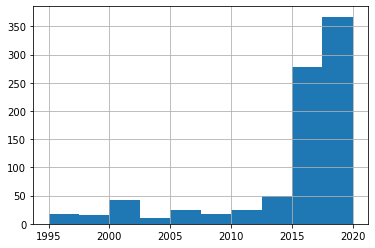

In [91]:
pd.to_datetime(pirads[pirads.EMPI.isin(pop_1.EMPI)]['Report_Date_Time']).dt.year.hist()

In [92]:
pop_1[pop_1.P_Score.isna()].EMPI

2       100095860
6       100237556
12      100006532
21      100006636
23      100026107
          ...    
4039    102653802
4045    111139002
4049    109908578
4050    110328050
4051    110682394
Name: EMPI, Length: 1836, dtype: int64

In [93]:
pop_1 = pop_1[['LNM','PSA','P_Score','overall_grade_merged', 'Wscore', 'race_cat',
       'Age at RP','hospital_rp_x','adenopathy','prostate_volume']] # Current features add more from Keith later
# Tyr Oversample from LNM 1

In [94]:
df_result = pop_1
print(df_result.shape)
for col in df_result.columns[:]:
    print(f'Number of Missing data for column {col} : ', df_result [col].isna().sum())
    print(df_result[col].value_counts())

(2387, 10)
Number of Missing data for column LNM :  0
0    2333
1      54
Name: LNM, dtype: int64
Number of Missing data for column PSA :  0
5.50     31
4.70     29
5.10     28
4.80     26
4.60     26
         ..
31.79     1
25.28     1
16.89     1
20.30     1
7.38      1
Name: PSA, Length: 906, dtype: int64
Number of Missing data for column P_Score :  1836
4.0    243
5.0    229
1.0     44
3.0     32
2.0      3
Name: P_Score, dtype: int64
Number of Missing data for column overall_grade_merged :  0
1.0    877
2.0    777
3.0    411
4.0    179
5.0    143
Name: overall_grade_merged, dtype: int64
Number of Missing data for column Wscore :  28
2.0     1712
0.0      550
3.0       37
1.0       26
8.0       19
4.0       10
9.0        2
10.0       1
5.0        1
6.0        1
Name: Wscore, dtype: int64
Number of Missing data for column race_cat :  2
White            2074
Black             138
Unknown/other      94
Hispanic           44
Asian              35
Name: race_cat, dtype: int64
Number of 

In [95]:
df_result

,LNM,PSA,P_Score,overall_grade_merged,Wscore,race_cat,Age at RP,hospital_rp_x,adenopathy,prostate_volume
2,0,1.1,NaN,1.0,NaN,NaN,NaN,MGH,NaN,NaN
5,0,0.8,4.0,3.0,0.0,White,56.0,MGH,0.0,85.000
6,0,5.1,NaN,5.0,0.0,White,40.0,BWH,NaN,16.380
7,0,4.1,5.0,3.0,2.0,White,66.0,MGH,0.0,24.000
12,0,3.3,NaN,2.0,0.0,Unknown/other,56.0,BWH,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
4047,0,7.6,3.0,4.0,2.0,Asian,64.0,MGH,0.0,32.000
4048,0,7.38,5.0,3.0,2.0,White,67.0,MGH,0.0,26.000
4049,0,7.65,NaN,3.0,0.0,White,68.0,FH,0.0,23.712
4050,0,6.5,NaN,2.0,2.0,White,57.0,MGH,NaN,NaN


In [96]:
df_result.to_csv('final1.csv',index=False)

# 2nd population: just drop missing PSA and Keep MRI features

In [ ]:
# TO DO:
# Fill missing PSA after Madhur verified extraction
# Add other features such as prostate Volume